In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from scripts.core import *

In [3]:
from scripts.learners import ModelLearner, ParallelLearner
from scripts.dataset import CSVData, MovingObjectData, SingleCSV
from scripts.loss import weightedMSE
import pickle

As loading and cleaning the dataset takes some time, we load the dataset and save it in a pickle file to be loaded below. This makes the process of loading the dataset quicker the next time we run the model.

In [45]:
data=MovingObjectData.fromCSVFolder("/home/sufiyan/data/Daimler/100_vids/csv/")
with open("/home/sufiyan/data/Daimler/100_vids/pickled_160_csv_14Feb", 'wb') as f:
    pickle.dump(data, f)

/home/sufiyan/MTP/code/Notebooks/scripts/dataset.py:209: DtypeWarning: Columns (2376,2504) have mixed types. Specify dtype option on import or set low_memory=False.
  if preload: self.data = [SingleCSV.fromCSV(self.files[i], **self.kwargs).data for i in range(self.__len__())]


Loading the dataset. To see how the dataset works, see [scripts/dataset.py](https://github.com/dumbPy/MTP/blob/master/scripts/dataset.py)

In [4]:
with open("/home/sufiyan/data/Daimler/100_vids/pickled_160_csv_14Feb", 'rb') as f:
    dataset=pickle.load(f)

In [5]:
path="/home/sufiyan/Common_data/mtp2/dataset/NEW/100_vids/"

Total number of files in the dataset

In [6]:
len(dataset)

161

Number of files for **Left**, **Right** and **Other** classes respectively. These include flipped files for Left and Right

In [7]:
print(len([1 for x,y in dataset if y==0]))
print(len([1 for x,y in dataset if y==1]))
print(len([1 for x,y in dataset if y==2]))

61
61
39


Seperating train and test files.

In [8]:
np.random.seed(10) #seting seed for always selecting same train and test set
totalFiles=len(dataset)
testFiles=np.random.choice(totalFiles, int(0.2*totalFiles)) #20% files as test files

Defining the Dataloaders for training and validation data

In [9]:
trainLoader=torch.utils.data.DataLoader([(x,y) for i,(x,y) in enumerate(dataset) if not i in testFiles])
testLoader=torch.utils.data.DataLoader([(x,y) for i,(x,y) in enumerate(dataset) if i in testFiles])

A simple model defined below is trained. It consists of a 2 Layer LSTM followed by a fully connected Layer

In [10]:
class CSVmodel(nn.Module):
    def __init__(self,categories=3, input_size=4, hidden_size=10, dropout=0.1):
        super().__init__()
        self.l1=nn.LSTM(input_size=input_size,hidden_size=hidden_size, dropout=dropout, num_layers=2)
        self.l2=nn.Linear(in_features=hidden_size,out_features=categories)
        self.softmax=nn.Softmax()
    def forward(self,x):
        x,_=self.l1(x)
        x=x[:,-1,:]
        x= self.l2(x)
        return x

ParallelLearner class takes ModelLearners that take models and other parameters like learning rate, optimization function and loss function.

In [12]:
learner=ParallelLearner(
                [ModelLearner(CSVmodel(), lr=0.001, loss_fn=partial(weightedMSE, [1,1,0.1]), 
                              optim=torch.optim.SGD, modelName='movingObjectDataModel' ),
                ModelLearner(CSVmodel(), lr=0.001, loss_fn=partial(weightedMSE, [0.5,0.5,0.1]), 
                             optim=torch.optim.SGD, modelName='movingObjectDataModel' ),
                ModelLearner(CSVmodel(), lr=0.001, loss_fn=torch.nn.MSELoss, optim=torch.optim.SGD, 
                             modelName='movingObjectDataModel' ),
                ModelLearner(CSVmodel(), lr=0.001, loss_fn=torch.nn.CrossEntropyLoss, 
                             optim=torch.optim.SGD, modelName='movingObjectDataModel' )],
        epochs=10, trainLoader=trainLoader, printEvery=102, validLoader=testLoader)

The ParallelLearner trains all the models parallelly by using the same data

In [13]:
learner.train(300)


**************************************************
Epoch: 101   Time Elapsed: 180.90190029144287
lr: 0.001      trainLoss: 0.16085467718993174
lr: 0.001      trainLoss: 0.08506680731520508
lr: 0.001      trainLoss: 0.2055754978774172
lr: 0.001      trainLoss: 1.0765285758358059
lr: 0.001      MSE validationLoss: 0.16290668937666664
lr: 0.001      MSE validationLoss: 0.0839960981031944
lr: 0.001      MSE validationLoss: 0.20516309655945877
lr: 0.001      CE validationLoss: 1.077730012351069


Avg Loss: 0.11654533445835114:   0%|          | 0/132 [00:00<?, ?it/s]          


**************************************************
Epoch: 203   Time Elapsed: 360.8289260864258
lr: 0.001      trainLoss: 0.15260552575416636
lr: 0.001      trainLoss: 0.08431612245851394
lr: 0.001      trainLoss: 0.19020974675588537
lr: 0.001      trainLoss: 1.06217486975771
lr: 0.001      MSE validationLoss: 0.15828177101653199
lr: 0.001      MSE validationLoss: 0.08391020883773935
lr: 0.001      MSE validationLoss: 0.18474472648110882
lr: 0.001      CE validationLoss: 1.0691689581706607


Plotting the loss for all the 4 models above. 

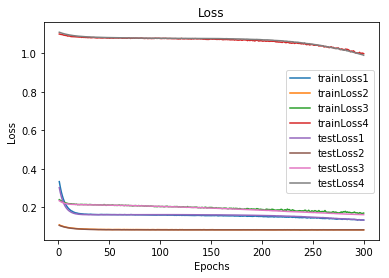

In [25]:
learner.plotLoss("Loss", ["trainLoss1", "trainLoss2", "trainLoss3", "trainLoss4"], 
                 ["testLoss1", "testLoss2","testLoss3","testLoss4"])

In [16]:
modLearner.num_samples_seen

39600

Plotting confusion matrix for training dataset for all the four loss functions namely weighted_MSE (1,1,0.1), weighted_MSE(0.5, 0.5, 0.1), MSE and CrossEntropyLoss.

In [18]:
print("wMSE1"); print(learner.learners[0].train_confusion_matrix_list[-1])
print("wMSE2"); print(learner.learners[1].train_confusion_matrix_list[-1])
print("MSE"); print(learner.learners[2].train_confusion_matrix_list[-1])
print("CE"); print(learner.learners[3].train_confusion_matrix_list[-1])

wMSE1
[[42  9  0]
 [11 38  0]
 [22 10  0]]
wMSE2
[[41 10  0]
 [36 13  0]
 [26  6  0]]
MSE
[[36 15  0]
 [ 5 44  0]
 [20 12  0]]
CE
[[48  3  0]
 [17 32  0]
 [23  9  0]]


In [19]:
learner.learners[2].loss

MSELoss()

Confision Matrix for all the loss functions for test data

In [20]:
print("wMSE1"); print(learner.learners[0].valid_confusion_matrix_list[-1])
print("wMSE2"); print(learner.learners[1].valid_confusion_matrix_list[-1])
print("MSE"); print(learner.learners[2].valid_confusion_matrix_list[-1])
print("CE"); print(learner.learners[3].valid_confusion_matrix_list[-1])

wMSE1
[[10  0  0]
 [ 4  8  0]
 [ 6  1  0]]
wMSE2
[[9 1 0]
 [8 4 0]
 [5 2 0]]
MSE
[[ 9  1  0]
 [ 2 10  0]
 [ 4  3  0]]
CE
[[10  0  0]
 [ 5  7  0]
 [ 6  1  0]]


We see above in test/validation data that the model does considerably well in MSE on **Left (0)** and **right (1)** classes, while it doesn't on **Other** classes (2). It doesn't perform well in weighted MSE class or Cross Entropy either. We will try to train the same model with weighted MSE with high weight to **Other (2)** class and see how it works below.

In [11]:
learner_2=ParallelLearner(
                [ModelLearner(CSVmodel(), lr=0.001, loss_fn=partial(weightedMSE, [1,1,2]), 
                              optim=torch.optim.SGD, modelName='movingObjectDataModel' ),
                 ModelLearner(CSVmodel(), lr=0.001, loss_fn=partial(weightedMSE, [1,1,5]), 
                              optim=torch.optim.SGD, modelName='movingObjectDataModel' ),
                 ModelLearner(CSVmodel(), lr=0.001, loss_fn=partial(weightedMSE, [1,1,10]), 
                              optim=torch.optim.SGD, modelName='movingObjectDataModel' )
                ],epochs=100, trainLoader=trainLoader, printEvery=102, validLoader=testLoader)

In [12]:
learner_2.train(100)

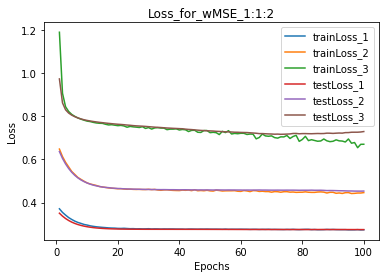

In [13]:
learner_2.plotLoss("Loss_for_wMSE_1:1:2",  ["trainLoss_1", "trainLoss_2", "trainLoss_3"], 
                                           ["testLoss_1", "testLoss_2", "testLoss_3"])

In [14]:
print("wMSE_1:1:2"); print(learner_2.learners[0].valid_confusion_matrix_list[-1])
print("wMSE_1:1:5"); print(learner_2.learners[1].valid_confusion_matrix_list[-1])
print("wMSE_1:1:10"); print(learner_2.learners[2].valid_confusion_matrix_list[-1])

wMSE_1:1:2
[[8 2 0]
 [3 9 0]
 [4 3 0]]
wMSE_1:1:5
[[1 9 0]
 [7 5 0]
 [6 1 0]]
wMSE_1:1:10
[[2 8 0]
 [2 6 4]
 [1 3 3]]


We see that, as we increase the weight for **Other (2)** class to 10, the model does tries to learn the class, but messes the other 2 classes. Other  than that, the model is not able to learn the **Other** class.

The above models were trained only with considering 4 columns representing MovingObjects as below

In [61]:
mov_data=MovingObjectData.fromCSVFolder("/home/sufiyan/data/Daimler/100_vids/csv/", preload=False)

/home/sufiyan/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (2376,2504) have mixed types. Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


Reason for Braking:  Pedestrian A


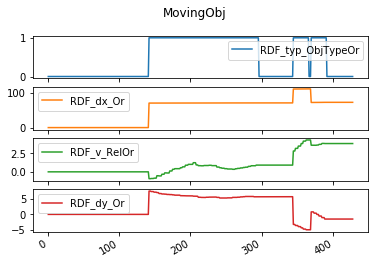

In [62]:
mov_data.plot(1)

As we see here, in the above plot, the model was trained on moving object data where as the ABA had reacted to a Pedestrian's presence and the moving object data is highly non-conclusive as to where the moving object is moving, if at all there is a moving object. Hence we will now try to train the model considering all 12 columns (4 corrosponding to ABA's reaction, Moving Object, Stationary object and Pedestrian each)

In [11]:
full_data=CSVData.fromCSVFolder("/home/sufiyan/data/Daimler/100_vids/csv/")
with open("/home/sufiyan/data/Daimler/100_vids/pickled_CSVData_160_csv_18Feb", 'wb') as f:
    pickle.dump(full_data, f)

/home/sufiyan/MTP/code/Notebooks/scripts/dataset.py:209: DtypeWarning: Columns (2376,2504) have mixed types. Specify dtype option on import or set low_memory=False.
  if preload: self.data = [SingleCSV.fromCSV(self.files[i], **self.kwargs).data for i in range(self.__len__())]


In [11]:
with open("/home/sufiyan/data/Daimler/100_vids/pickled_CSVData_160_csv_18Feb", 'rb') as f:
    full_data=pickle.load(f)

/home/sufiyan/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (2376,2504) have mixed types. Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


Reason for Braking:  Pedestrian A


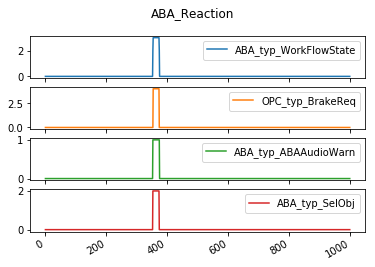

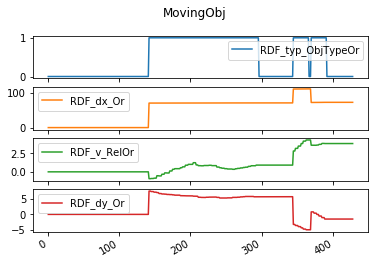

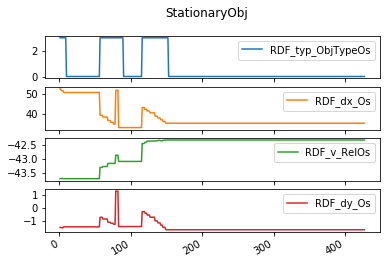

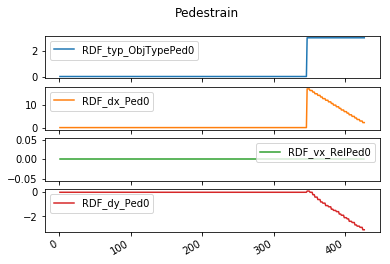

In [12]:
full_data.plot(1)

When we use the full data i.e., [scripts/dataset.CSVData](https://github.com/dumbPy/MTP/blob/3d9ca8ab8b395ae1592e49f38cc503bb5fafedf4/scripts/dataset.py#L203), we see that for the same file, we get all the columns and we hope the simple model defined above might be able to detect **Other (2)** class better.

Let's try to train the model with full  data and see how the model reacts to it

In [41]:
trainLoader=torch.utils.data.DataLoader([(x,y) for i,(x,y) in enumerate(full_data) if not i in testFiles])
testLoader=torch.utils.data.DataLoader([(x,y) for i,(x,y) in enumerate(full_data) if i in testFiles])

In [42]:
learner_3=ParallelLearner([
                ModelLearner(CSVmodel(input_size=16, hidden_size=20), 
                             lr=0.001, loss_fn=torch.nn.MSELoss, 
                             optim=torch.optim.SGD, modelName='CSVModel_full_data_1' ),
                ModelLearner(CSVmodel(input_size=16, hidden_size=20), 
                             lr=0.001, loss_fn=torch.nn.CrossEntropyLoss, 
                             optim=torch.optim.SGD, modelName='CSVModel_full_data_2' ),
                ModelLearner(CSVmodel(input_size=16, hidden_size=20), 
                              lr=0.001, loss_fn=partial(weightedMSE, [1,1,2]), 
                              optim=torch.optim.SGD, modelName='CSVModel_full_data_3' ),
                ModelLearner(CSVmodel(input_size=16, hidden_size=20), 
                             lr=0.001, loss_fn=partial(weightedMSE, [1,1,5]), 
                             optim=torch.optim.SGD, modelName='CSVModel_full_data_4' )],
        epochs=100, trainLoader=trainLoader, printEvery=102, validLoader=testLoader)

In [43]:
learner_3.train(epochs=100)

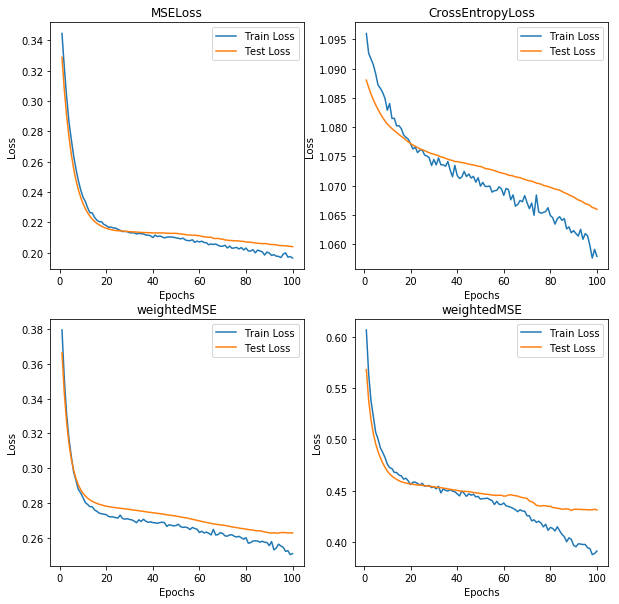

In [45]:
learner_3.plotLoss(figsize=(10,10))

Plotting Confusion Matrix on train data

In [46]:
print("MSE"); print(learner_3.learners[0].train_confusion_matrix_list[-1])
print("CE"); print(learner_3.learners[1].train_confusion_matrix_list[-1])
print("wMSE_1:1:2"); print(learner_3.learners[2].train_confusion_matrix_list[-1])
print("wMSE_1:1:5"); print(learner_3.learners[3].train_confusion_matrix_list[-1])

MSE
[[42  9  0]
 [10 39  0]
 [31  1  0]]
CE
[[39 12  0]
 [19 30  0]
 [29  3  0]]
wMSE_1:1:2
[[39 12  0]
 [14 35  0]
 [29  3  0]]
wMSE_1:1:5
[[36 15  0]
 [ 9 39  1]
 [30  1  1]]


Plotting Confusion Matrix on validation/test data

In [47]:
print("MSE"); print(learner_3.learners[0].valid_confusion_matrix_list[-1])
print("CE"); print(learner_3.learners[1].valid_confusion_matrix_list[-1])
print("wMSE_1:1:2"); print(learner_3.learners[2].valid_confusion_matrix_list[-1])
print("wMSE_1:1:5"); print(learner_3.learners[3].valid_confusion_matrix_list[-1])

MSE
[[7 3 0]
 [3 9 0]
 [6 1 0]]
CE
[[ 5  5  0]
 [ 2 10  0]
 [ 5  2  0]]
wMSE_1:1:2
[[ 5  5  0]
 [ 2 10  0]
 [ 7  0  0]]
wMSE_1:1:5
[[8 2 0]
 [3 9 0]
 [5 2 0]]


#### The model output after training with full 16 columns is still non-conclusive.